In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, RepeatedKFold
import numpy as np
from itertools import combinations
import statsmodels.api as sm
import statsmodels.tools as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import matplotlib.pyplot as plt
import pprint
import statistics
import time
%matplotlib inline

In [18]:
response = 'rheomix final deg time min'
# response = 'rheomix stability time min'

repetition = 100
redo = 5
rorder = 1

In [19]:
list_kmin = []
model_kmin = []
list1 = ['k3','k5','k10','k15','k20','LOO']
list_k_no = [3,5,10,15,20,'LOO']

for i in list1:
    file1 = 'Total_model_subset_{}_Kfold_{}.csv'.format(response, i)
    df_kfold = pd.read_csv(file1)
    min_index = df_kfold[i].argmax()
    list_kmin.append(df_kfold[i][min_index])
    model_kmin.append(df_kfold['Model'][min_index])
model_kmin

['--Xpvc--Xfr--Xstabiliser--Xdinp--Xldh--Xpvc*Xstabiliser--Xfr*Xstabiliser--Xstabiliser*Xldh--Xdinp*Xldh--',
 '--Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xstabiliser*Xldh--Xdinp*Xldh--',
 '--Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xstabiliser*Xldh--Xdinp*Xldh--',
 '--Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xstabiliser*Xldh--Xdinp*Xldh--',
 '--Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xstabiliser*Xldh--Xdinp*Xldh--',
 '--Xpvc--Xfiller--Xfr--Xstabiliser--Xdinp--Xldh--Xfr*Xstabiliser--Xstabiliser*Xldh--Xdinp*Xldh--']

In [20]:
def import_data(experimental_file, response_file, response):
    'imports data'
    'experimental_file = experimental design csv filename i.e experimental.csv'
    'response_file = results csv filename i.e Response.csv'
    'response = reponse name: i.e rheomix final deg time min or rheomix stability time min'
    
    experimental_df = pd.read_csv(experimental_file)
    response_df = pd.read_csv(response_file)
    
    X = experimental_df[experimental_df.columns.values.tolist()[1:]].values
    y = response_df[response].values
    max1 = max(y)
    min1 = min(y)

    y_norm = [2*((i-min1)/(max1-min1)) - 1 for i in y]
    
    
    X_linear = X
    linear_terms = experimental_df.columns.values.tolist()[1:]
    
    return y_norm, X_linear, linear_terms, experimental_df, response_df

def X_gen(model, X_linear):
    
    for i, j in enumerate(model):
        
        if i == 0 and len(j) == 2: 
            X_new = X_linear[:, model[0][1]]
        
        else:
            
            if len(j) == 2:
                add = X_linear[:, j[1]]

            if len(j) == 3:
                add = X_linear[:, j[1]]*X_linear[:, j[2]]

            X_new2 = np.column_stack((X_new, add))
            X_new = X_new2

    
    return X_new

In [21]:
dict1 = {'Xpvc': 0, 'Xfiller': 1, 'Xfr': 2, 'Xstabiliser': 3, 'Xdinp': 4, 'Xldh':5, "Xsph": 6}
experimental_file = 'experimental.csv'
response_file = 'Response.csv'

y, X_linear, linear_terms, experimental_df, response_df = import_data(experimental_file, response_file, response)
y1 = np.array(y)

list_k3 = []
list_k5 = []
list_k10 = []
list_k15 = []
list_k20 = []
list_loo = []

list_kall = [list_k3, list_k5, list_k10, list_k15, list_k20, list_loo]

for model, k_folds, list_k in zip(model_kmin, list_k_no, list_kall):
    
    cnt = 0                  
    a = model.split('--')[1:-1]
    model_fin = []
    for b in a:
        if len(b.split('*')) == 1:
            model_fin.append([b, dict1[b]])
        else:
            model_fin.append([b, dict1[b.split('*')[0]], dict1[b.split('*')[1]]])
            
    X = X_gen(model_fin, X_linear)
    
    
    for loop_rep in range(repetition):
        
            rs = ShuffleSplit(n_splits=1, train_size = 3/4, random_state= loop_rep)
            rs.get_n_splits(X)
            for subset_index, _ in rs.split(X):
                X_subset, Y_subset, = X[subset_index], y1[subset_index]
                
            if k_folds == 'LOO':
                k_folds = len(X_subset)
                redo1 = 1
            else:
                redo1 = redo

            if len(model_fin) == 1:

                X1 = X_subset.reshape(len(X_subset), 1)
                model_obj = LinearRegression(fit_intercept=False)
                my_cv = RepeatedKFold(n_splits=k_folds, random_state= rorder, n_repeats = redo1)
                
                score = cross_val_score(model_obj, X1, Y_subset, cv=my_cv, scoring='neg_mean_squared_error')
                av_score = sum(score)/len(score)
                
            else:

                model_obj = LinearRegression(fit_intercept=False)
                my_cv = RepeatedKFold(n_splits=k_folds, random_state= rorder, n_repeats = redo1)
                
                score = cross_val_score(model_obj, X_subset, Y_subset, cv=my_cv, scoring='neg_mean_squared_error')
                av_score = sum(score)/len(score)
            
            list_k.append(av_score)

list_sd = []
list_kmin = []
for i in list_kall:
    sd = statistics.stdev(i)
    k = sum(i)/len(i)
    list_sd.append(sd)
    list_kmin.append(k)

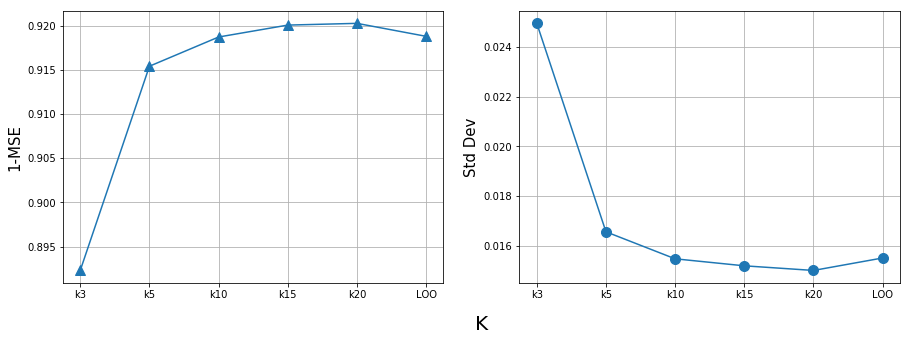

In [22]:
Ylabel = '1-MSE'
Ylabel2 = 'Std Dev'
Xlabel = 'K'

plotVar1label = 'K-fold'
plotVar2label = 'AICc'

LegendLocation = 'best'
Grid = True
LegendSize = 12
FontSize = 20
FontSizey = 15

fig, ax = plt.subplots(1, 2, sharex=True)

ax[0].plot(list1, [1+i for i in list_kmin], "-^", label=plotVar1label, markersize=10)
ax[1].plot(list1, list_sd, "-o", label=plotVar2label, markersize=10)

# ax[0].set_title('K-fold:', fontsize=16, pad = 10)
# ax[1].set_title('AICc:', fontsize=16, pad = 10)


# ax[0].axis([0, 26, 0 , 120])
# ax[1].axis([0, 26, 0 , 0.4])

# plt.xlim([0, 26])

# ax[1,0].axis([0, 26, 0 , 0.15])
# fig.legend(loc='best', numpoints = 1, fontsize=FontSize, prop={'size':LegendSize})
# fig.delaxes(ax[1][1])

# ax[0].set_xticks(no_terms_list[:20])
# ax[0].set_xticks([2*(i+1) for i in range(10)])
# ax[1].set_xticks([2*(i+1) for i in range(10)])

fig.set_figheight(5)
fig.set_figwidth(15)
# # plt.legend(loc=1, numpoints = 1, fontsize=FontSize, prop={'size':LegendSize})

# fig.ylabel(Ylabel, fontsize=FontSize)
# # fig.xlabel(Xlabel, fontsize=FontSize)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

ax[0].set_ylabel(Ylabel, fontsize=FontSizey, labelpad=5)
ax[1].set_ylabel(Ylabel2, fontsize=FontSizey, labelpad=5)

# plt.ylabel(Ylabel, fontsize=FontSize, labelpad=25)
plt.xlabel(Xlabel, fontsize=FontSize, labelpad=15)
# plt.xlabel(Xlabel)
# # plt.tick_params(axis='x', labelsize=FontSize)
# # plt.tick_params(axis='y', labelsize=FontSize)
ax[0].grid(zorder = 0)
ax[1].grid(zorder = 0)
# ax[1,0].grid(zorder = 0)

# fig.tight_layout()
# fig.tight_layout()
fig.savefig('Kfold_compare_bias_dev_{}.png'.format(response), bbox_inches = "tight")

plt.show()